In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import pandas as pd
import numpy as np
import networkx

from matplotlib import pyplot as plt

%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy import linalg
from sklearn.neighbors._kde import KernelDensity
from sklearn.covariance import GraphicalLassoCV

import warnings

warnings.simplefilter("ignore")

df = pd.read_csv("../data/watertreatment_mod.csv", header=0, index_col=0)
TimeIndices = df.index
df.head()

window_size = 10
cr = 0.99

In [3]:
# 分割ポイント
split_point = 100
# 学習データ（train）と評価データ（test）に分割
train_df = df.iloc[
    : (split_point - 1),
]
test_df = df.iloc[
    split_point:,
]

# データを標準化
sc = StandardScaler()
sc.fit(train_df)
train_df_std = sc.transform(train_df)
test_df_std = sc.transform(test_df)

In [4]:
# 共分散の推定
n_samples, n_features = train_df_std.shape
emp_cov = np.dot(train_df_std.T, train_df_std) / n_samples

model = GraphicalLassoCV()
model.fit(train_df_std)
cov_ = model.covariance_
prec_ = model.precision_

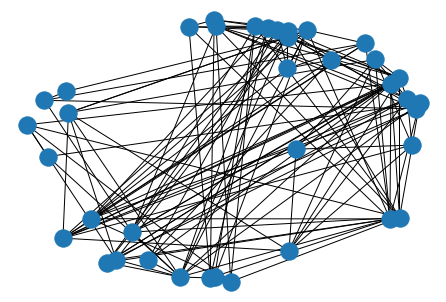

In [5]:
graph = networkx.from_numpy_matrix(prec_)
networkx.draw(graph)

In [6]:
# KL距離を計算する
# cov_・・・正常データの共分散行列
# prec_・・・正常データの精度行列
def Calc_KL(cov_, prec_, xtest):
    """KL距離の計算を行う

    Parameters
    ----------
    cov_ : np.array
        学習データの共分散行列
    prec_ : np.array
        学習データの精度行列
    df : pd.DataFrame
        データセット

    Returns
    -------
    d_ab : pd.DataFrame
        KL距離
    """
    n_samples, n_features = xtest.shape

    d_abp = np.zeros(n_features)
    d_abm = np.zeros(n_features)
    d_ab = np.zeros(n_features)

    model_test = GraphicalLassoCV()
    try:
        model_test.fit(xtest)
    except FloatingPointError:
        print("floating error")
        return d_ab

    cov__test = model_test.covariance_
    prec__test = model_test.precision_

    # 変数毎に相関の崩れの大きさを計算する
    for i in range(n_features):
        temp_prec_a = np.r_[prec_[i:n_features, :], prec_[0:i, :]]
        temp_prec_a = np.c_[temp_prec_a[:, i:n_features], temp_prec_a[:, 0:i]]
        temp_prec_b = np.r_[prec__test[i:n_features, :], prec__test[0:i, :]]
        temp_prec_b = np.c_[temp_prec_b[:, i:n_features], temp_prec_b[:, 0:i]]
        temp_cov_a = np.r_[cov_[i:n_features, :], cov_[0:i, :]]
        temp_cov_a = np.c_[temp_cov_a[:, i:n_features], temp_cov_a[:, 0:i]]
        temp_cov_b = np.r_[cov__test[i:n_features, :], cov__test[0:i, :]]
        temp_cov_b = np.c_[temp_cov_b[:, i:n_features], temp_cov_b[:, 0:i]]
        La = temp_prec_a[:-1, :-1]
        la = temp_prec_a[:-1, -1]
        lama = temp_prec_a[-1, -1]
        Wa = temp_cov_a[:-1, :-1]
        wa = temp_cov_a[:-1, -1]
        sigmaa = temp_cov_a[-1, -1]
        Lb = temp_prec_b[:-1, :-1]
        lb = temp_prec_b[:-1, -1]
        lamb = temp_prec_b[-1, -1]
        Wb = temp_cov_b[:-1, :-1]
        wb = temp_cov_b[:-1, -1]
        sigmab = temp_cov_b[-1, -1]

        d_abp[i] = (
            np.dot(wa, la)
            + 0.5 * (np.dot(np.dot(lb, Wb), lb) - np.dot(np.dot(la, Wa), la))
            + 0.5 * (np.log(lama / lamb) + sigmaa - sigmab)
        )
        d_abm[i] = (
            np.dot(wb, lb)
            + 0.5 * (np.dot(np.dot(la, Wa), la) - np.dot(np.dot(lb, Wb), lb))
            + 0.5 * (np.log(lamb / lama) + sigmab - sigmaa)
        )
        d_ab[i] = max(-d_abp[i], -d_abm[i])

    return d_ab

In [7]:
# カーネル密度推定によるコントロールリミットの計算
def cl_limit(x, cr=0.99):
    """管理限界の計算を行う

    Parameters
    ----------
    x : np.array
        KL距離
    cr : float
        管理限界の境界

    Returns
    -------
    cl : float
        管理限界の境界点
    """
    X = x.reshape(np.shape(x)[0], 1)
    bw = (np.max(X) - np.min(X)) / 100
    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(X)
    X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    prob = np.exp(log_dens) / np.sum(np.exp(log_dens))
    calprob = np.zeros(np.shape(prob)[0])
    calprob[0] = prob[0]
    for i in range(1, np.shape(prob)[0]):
        calprob[i] = calprob[i - 1] + prob[i]

    cl = X_plot[np.min(np.where(calprob > cr))]

    return cl

In [8]:
# 学習データでクロスバリデーション
# 学習データをK分割
K = 5
cv_data_size = np.int(np.shape(train_df_std)[0] / 5)
n_train_samples = np.shape(train_df_std)[0]
counter = 0

for i in range(K):

    cv_train_data = np.r_[
        train_df_std[0 : i * cv_data_size,], train_df_std[(i + 1) * cv_data_size :,]
    ]
    if i < K - 1:
        cv_test_data = train_df_std[
            i * cv_data_size : (i + 1) * cv_data_size,
        ]
    else:
        cv_test_data = train_df_std[
            i * cv_data_size :,
        ]

    model_cv = GraphicalLassoCV()
    model_cv.fit(cv_train_data)
    cov__cv = model.covariance_
    prec__cv = model.precision_

    for n in range(window_size, np.shape(cv_test_data)[0]):
        count = i * cv_data_size + n
        tempX = cv_test_data[n - window_size : n, :]
        d_ab_temp = Calc_KL(cov__cv, prec__cv, tempX)

        if 0 == counter:
            d_ab = d_ab_temp.reshape(1, n_features)
            TimeIndices2 = TimeIndices[count]
        else:
            d_ab = np.r_[d_ab, d_ab_temp.reshape(1, n_features)]
            # ここでerror
            TimeIndices2 = np.vstack((TimeIndices2, TimeIndices[count]))

        counter = counter + 1

split_point = np.shape(d_ab)[0]
d_ab_cv = d_ab[np.sum(d_ab, axis=1) != 0, :]

cl = np.zeros([n_features])
for i in range(n_features):
    cl[i] = cl_limit(d_ab_cv[:, i], cr)

In [9]:
# 評価データに対しても共分散を推定
n_test_samples = np.shape(test_df_std)[0]

for n in range(window_size, n_test_samples):
    tempX = test_df_std[n - window_size : n, :]

    d_ab_temp = Calc_KL(cov_, prec_, tempX)

    d_ab = np.r_[d_ab, d_ab_temp.reshape(1, n_features)]
    TimeIndices2 = np.vstack((TimeIndices2, TimeIndices[n + n_train_samples]))

floating error
floating error
floating error
floating error
floating error
floating error
floating error
floating error
floating error


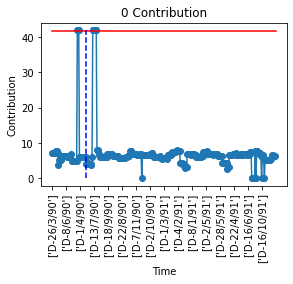

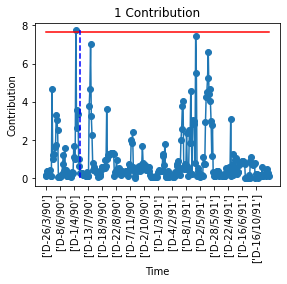

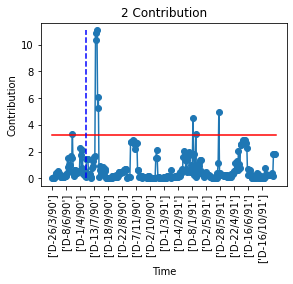

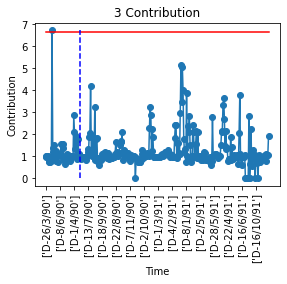

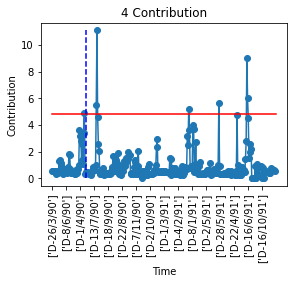

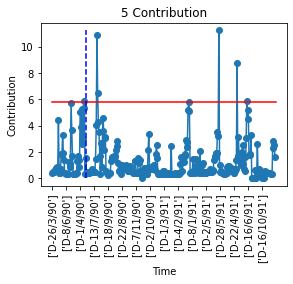

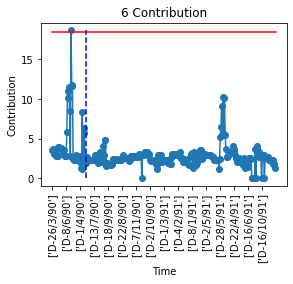

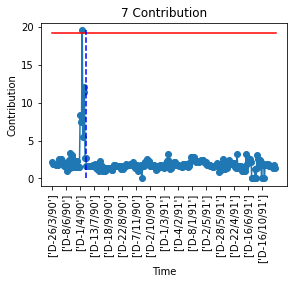

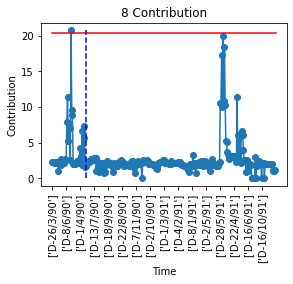

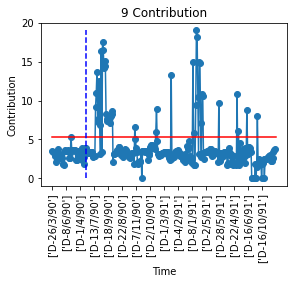

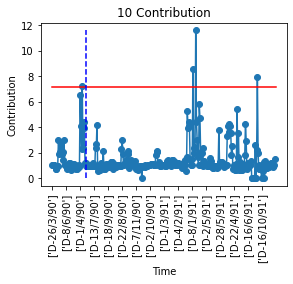

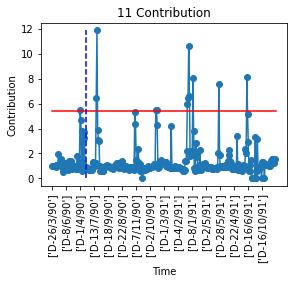

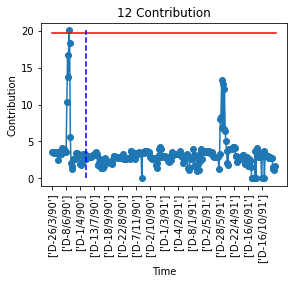

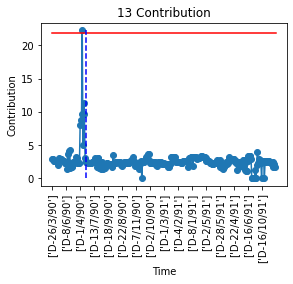

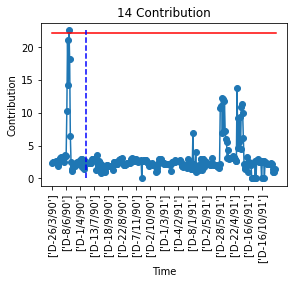

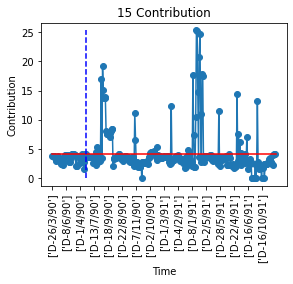

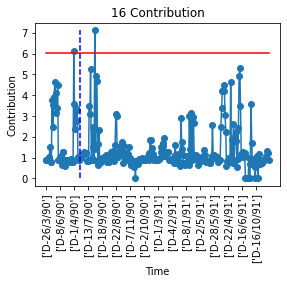

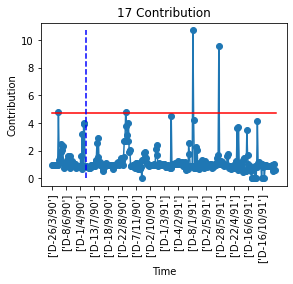

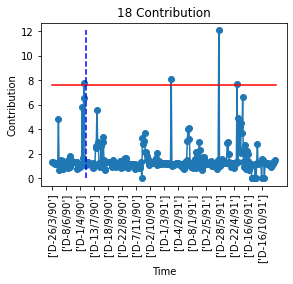

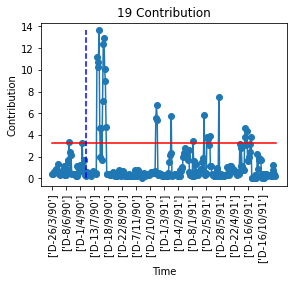

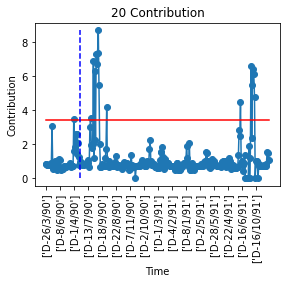

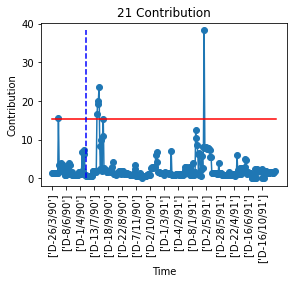

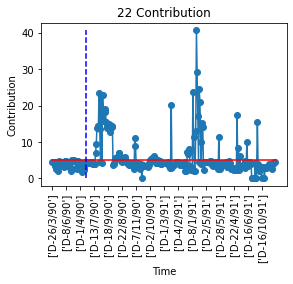

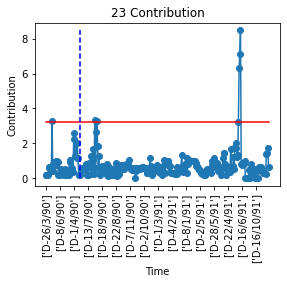

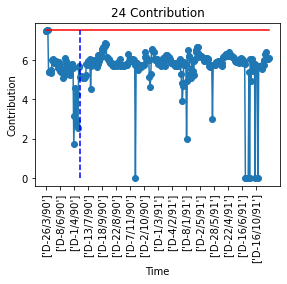

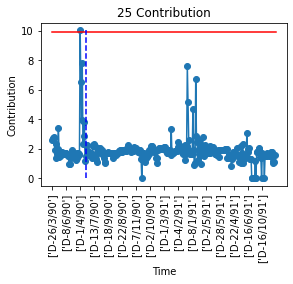

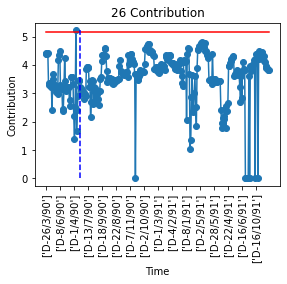

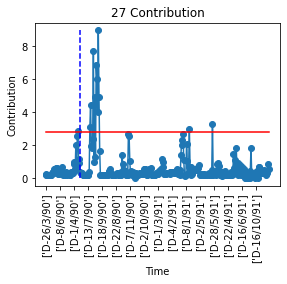

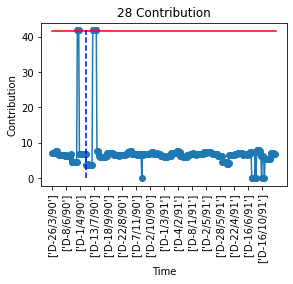

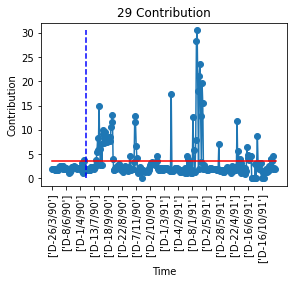

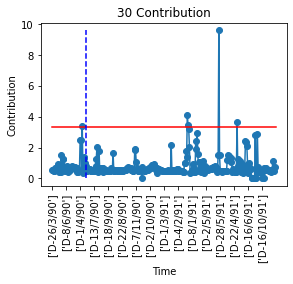

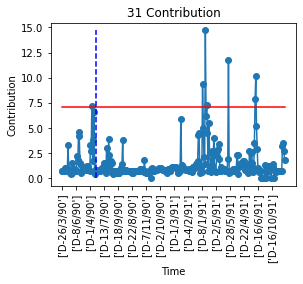

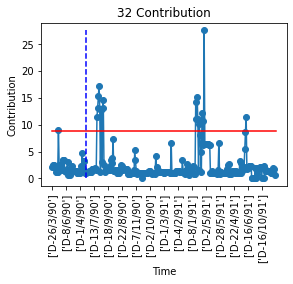

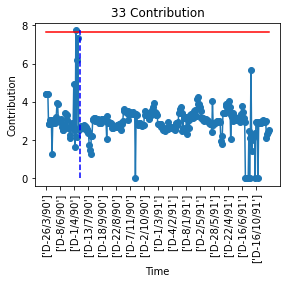

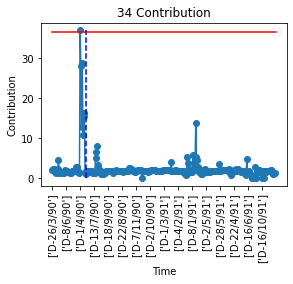

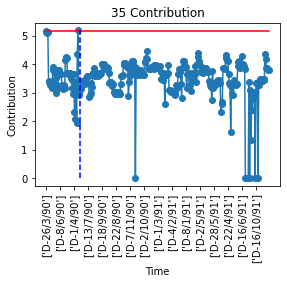

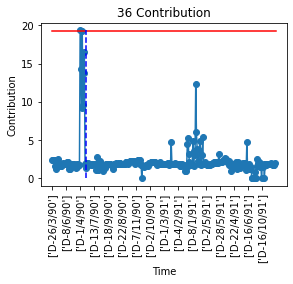

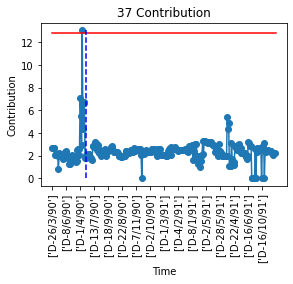

In [10]:
x2 = [0, np.shape(d_ab)[0]]
x3 = [split_point, split_point]
x = range(0, np.shape(TimeIndices2)[0], 20)
NewTimeIndices = np.array(TimeIndices2[x])
for i in range(38):
    plt.figure(figsize=(200, 3))
    plt.subplot(1, 38, i + 1)
    plt.title("%s Contribution" % (i))
    plt.plot(d_ab[:, i], marker="o")
    plt.xlabel("Time")
    plt.ylabel("Contribution")
    plt.xticks(x, NewTimeIndices, rotation="vertical")
    y2 = [cl[i], cl[i]]
    plt.plot(x2, y2, ls="-", color="r")
    y3 = [0, np.nanmax(d_ab[:, i])]
    plt.plot(x3, y3, ls="--", color="b")

plt.show()